## RAID notebook: Raster Calculations

In [4]:

import os
import sys
import imp

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import gdal


cur_dir = os.getcwd()
modulePath=os.path.join(cur_dir,os.pardir)
sys.path.insert(0,modulePath)
import raidnr.bwgrid.grid_transformations as gt





In [11]:


osPath=os.path.join(modulePath,"data","shp","OS","data")
shpPath=os.path.join(modulePath,"data","shp")


cur_dir= os.getcwd()
inputPath=os.path.join(cur_dir,"notebook_data","raster_calculations")



#### Read from txt file

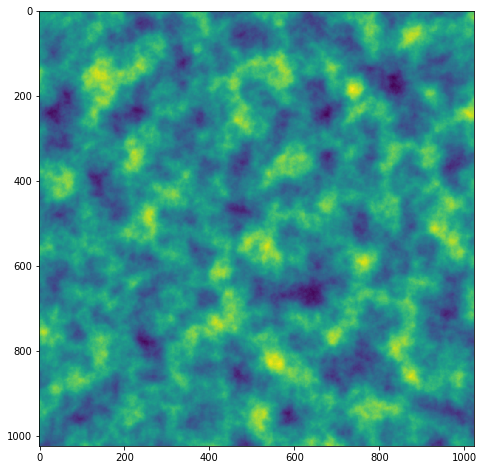

In [12]:
fileName= "world.txt"
filePath = os.path.join(inputPath,fileName)

# IMPORTANT
# dtype = float
world_ = np.loadtxt(filePath, dtype=float)


fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(world_)

#### Read from raster tif

In [13]:
fileName= "SE_Woodland.tif"

rasterFile= os.path.join(inputPath,fileName)
ds = gdal.Open(rasterFile)
tif_raster = np.array(ds.GetRasterBand(1).ReadAsArray())
raster_size=(ds.RasterYSize,ds.RasterXSize)


fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(tif_raster)

##### Metadata from a tif file

In [14]:
# extract bounding box from the raster file
transform = ds.GetGeoTransform()
xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

cols = ds.RasterXSize
rows = ds.RasterYSize

# bbox = [xmin,ymin,xmax,ymax]

bbox = [xOrigin,yOrigin-rows*pixelHeight,xOrigin+cols*pixelWidth,yOrigin]

print("bbox is", bbox)



bbox is [404090.6344816111, 411100.40906368574, 408359.6344816111, 414931.40906368574]


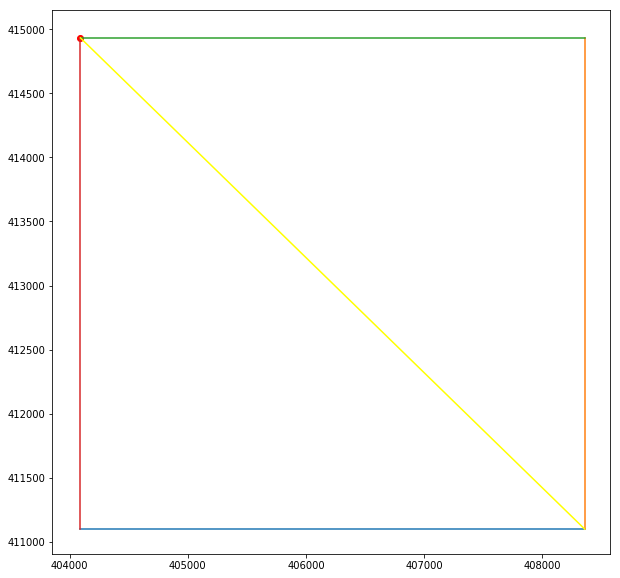

In [15]:

#     A (xmin,ymax)= (bbox[0],bbox[3])      D(xmax,ymax)=(bbox[2],bbox[3])     
#     .-------------------------------------.
#     |                                     |
#     |            Bounding box             |
#     |                                     |
#     .-------------------------------------.
#     B(xmin,ymin)= (bbox[0],bbox[1])       C(xmax,ymin)= (bbox[2],bbox[1])


fig,ax = plt.subplots(figsize=(10,10))

# positional args of the bbox array
xIndicies=[0,2,2,0,0]
yIndicies=[1,1,3,3,1]

for i in range(1,len(xIndicies)):
    ax.plot((bbox[xIndicies[i-1]],bbox[xIndicies[i]]),(bbox[yIndicies[i-1]],bbox[yIndicies[i]]))

ax.scatter(xOrigin,yOrigin,c='red') 
ax.plot((xOrigin,xOrigin+cols*pixelWidth),(yOrigin,yOrigin-rows*pixelHeight),c='yellow')
plt.show()

#### Plotting raster

Important, that the raster coordinates differ from the often kardesian system which has the start of the axis 
located in the bottom left corner. Instead raster have the origin in the TOP LEFT corner.

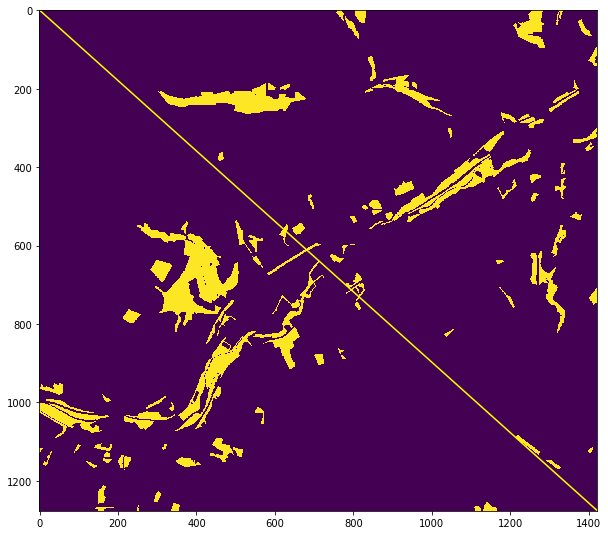

In [16]:
fig,ax = plt.subplots(figsize=(10,10))

start_coord = (0,0)
end_coord= (rows,cols)

rasterY,rasterX= zip(start_coord,end_coord)

ax.plot(rasterX,rasterY,c='yellow')
plt.imshow(tif_raster)

#### Transform coordinates from geo to raster

In [17]:
#lets try to transform the bbox coordinates

xCoords=np.array(bbox)[xIndicies]
yCoords= np.array(bbox)[yIndicies]


bounding_box_coords=list(zip(xCoords,yCoords))

# we assume know that pixelHeight== pixelWidth
bounding_box_raster_coords=[gt.coords_geo_to_raster(bbox,i,pixelHeight) for i in bounding_box_coords]


In [18]:
bounding_box_raster_coords

[(1277, 0), (1277, 1423), (0, 1423), (0, 0), (1277, 0)]

In [19]:
fig,ax = plt.subplots(figsize=(10,10))

c=['red','yellow','green','blue','red']
cIndex=0
for i in bounding_box_raster_coords:
    ax.scatter(i[1],i[0],s=100,c=c[cIndex])
    cIndex+=1
    
ax.imshow(tif_raster)   

origin=(1000,500)
end = (100,500)
yraster,xraster=zip(origin,end)


# NOTICE THAT 
# input coordinates for the scatter plot
# need to be reversed

ax.scatter(origin[1],origin[0],c='red')
ax.scatter(end[1],end[0],c='green')
ax.plot(xraster,yraster)

plt.show()

#### Transform raster coordinates to geo

In [21]:
raster_coords=list(zip(yCoords,xCoords))

geo_coords=[gt.raster_to_coords(bbox,i) for i in raster_coords]
geo_lat,geo_lon=zip(*geo_coords)


### Query data in a raster

#### Set up a kernel

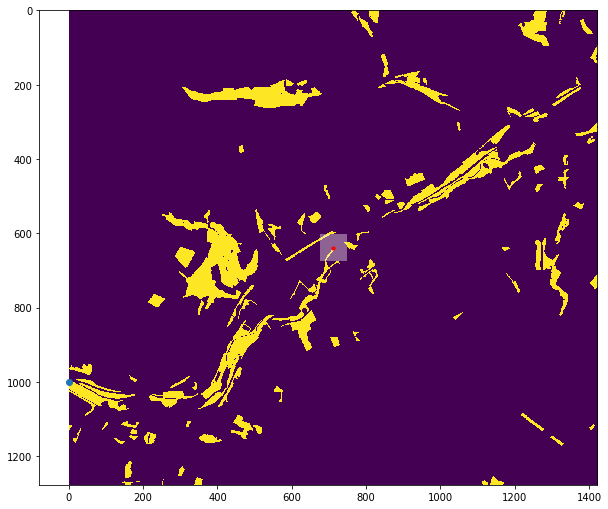

In [22]:

centerOn=( int(raster_size[0]/2),int(raster_size[1]/2))

#size of kernel needs to be an odd number
ksize=71


mask=np.zeros_like(tif_raster)

mask[centerOn[0]-ksize//2:centerOn[0]+1+ksize//2,centerOn[1]-ksize//2:centerOn[1]+1+ksize//2] = 1 

masked = np.ma.masked_where(mask == 0, mask)




fig,ax = plt.subplots(figsize=(10,10))

plt.imshow(tif_raster)
# plt.imshow(testarray[:,:,10],alpha=0.4)

plt.imshow(masked,'Reds',alpha=0.4)
plt.scatter(centerOn[1],centerOn[0],s=10,c='red')

plt.scatter(0,1000)

# plt.xlim(wx[centerOn]-100,wx[centerOn]+100)
# plt.ylim(wy[centerOn]-100,wy[centerOn]+100)

#### Query raster on a line between two points

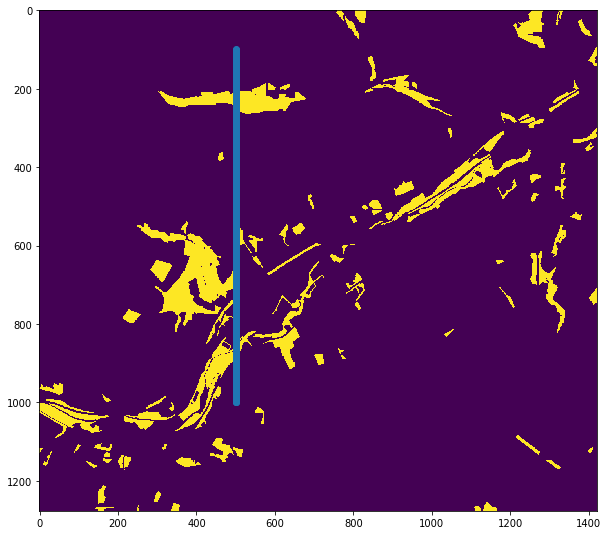

In [23]:
fig,ax = plt.subplots(figsize=(10,10))
import skimage.draw

# skimage takes coordinates in the form of rasterx,rastery
x,y=skimage.draw.line(origin[1],origin[0],end[1],end[0])
ax.scatter(x,y)
ax.imshow(tif_raster)

plt.show()

#### Use of gt.return_cost function

In [24]:
gt.return_cost(tif_raster,0,400,1000,ksize=30)

array([147645.])

### Distance Transform

In [29]:
from scipy import ndimage
tif_raster_copy = tif_raster.copy()

tif_raster_copy[400,400]=0

naa_layer = ndimage.distance_transform_edt(tif_raster_copy)


In [51]:
tif_raster_copy = np.zeros_like(tif_raster)
tif_raster_copy = np.add(tif_raster_copy, np.inf,casting="unsafe")

tif_raster_copy[np.where(tif_raster==255)]=0
tif_raster_copy = ndimage.distance_transform_edt(tif_raster_copy)


In [52]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(tif_raster_copy)

# ax.set_xlim(400,600)
# ax.set_ylim(1000,800)
plt.show()